In [4]:
import os
import torch
import pandas as pd
import numpy as np
from google.colab import files
from torch.utils.data import Dataset, DataLoader
# AdamW buradan kaldirildi
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
# AdamW buraya eklendi (Dogrusu budur)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shutil

# 1. DOSYA YUKLEME
print("Lutfen 'augmented_train_data.csv' dosyasini secin:")
uploaded = files.upload()
filename = next(iter(uploaded))

# 2. KURULUM
print("[KURULUM] Kutuphaneler yukleniyor...")
!pip install transformers -q

# 3. AYARLAR
MODEL_NAME = "dbmdz/electra-base-turkish-cased-discriminator"
BATCH_SIZE = 32
EPOCHS = 4
MAX_LEN = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[BILGI] Egitim Cihazi: {device}")

# 4. DATASET SINIFI
class ToxicDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.texts = df['cleaned_text'].values
        # Etiketleri al (Toxic, Profanity, Insult, Hate Speech)
        self.labels = df[['is_toxic', 'is_profanity', 'is_insult', 'is_hate_speech']].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

# 5. EGITIM FONKSIYONU
def train():
    df = pd.read_csv(filename)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

    train_dataset = ToxicDataset(train_df, tokenizer, MAX_LEN)
    val_dataset = ToxicDataset(val_df, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4, problem_type="multi_label_classification")
    model.to(device)

    # Duzeltilen Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print("\n[BASLIYOR] Egitim baslatildi...")

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()
            outputs = model(input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=mask, labels=labels)
                val_loss += outputs.loss.item()

                preds = torch.sigmoid(outputs.logits).cpu().numpy()
                all_preds.extend((preds > 0.5).astype(int))
                all_labels.extend(labels.cpu().numpy())

        f1 = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)[2]
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | F1 Score: {f1:.4f}")

    # 6. KAYDETME VE INDIRME
    print("\n[KAYIT] Model kaydediliyor ve sikistiriliyor...")
    output_dir = "toxic_model_colab"
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    shutil.make_archive("toxic_model_v2", 'zip', output_dir)
    files.download("toxic_model_v2.zip")
    print("[SON] 'toxic_model_v2.zip' indirme islemi baslatildi!")

if __name__ == "__main__":
    train()

Lutfen 'augmented_train_data.csv' dosyasini secin:


Saving augmented_train_data.csv to augmented_train_data (1).csv
[KURULUM] Kutuphaneler yukleniyor...
[BILGI] Egitim Cihazi: cuda


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at dbmdz/electra-base-turkish-cased-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



[BASLIYOR] Egitim baslatildi...
Epoch 1/4 | Train Loss: 0.4784 | Val Loss: 0.3277 | F1 Score: 0.6393
Epoch 2/4 | Train Loss: 0.3056 | Val Loss: 0.2575 | F1 Score: 0.7987
Epoch 3/4 | Train Loss: 0.2443 | Val Loss: 0.2383 | F1 Score: 0.8438
Epoch 4/4 | Train Loss: 0.2115 | Val Loss: 0.2328 | F1 Score: 0.8426

[KAYIT] Model kaydediliyor ve sikistiriliyor...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SON] 'toxic_model_v2.zip' indirme islemi baslatildi!


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Modeli Yukle (Az once kaydettigimiz klasorden)
MODEL_PATH = "toxic_model_colab"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"[TEST] Model yukleniyor: {MODEL_PATH}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
    model.to(device)
    model.eval()
    print("[TEST] Model basariyla yuklendi! Teste hazir.")
except Exception as e:
    print(f"[HATA] Model bulunamadi. Once egitim kodunu calistirdiginizdan emin olun.\nHata: {e}")

# Etiketlerimiz
LABELS = ['Toxic', 'Profanity', 'Insult', 'Hate Speech']

def predict_colab(text):
    # Basit temizlik (Lokaldekiyle ayni mantik)
    cleaned_text = text.replace("I", "ı").replace("İ", "i").lower()

    inputs = tokenizer(
        cleaned_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Olasiliklari hesapla
    probs = torch.sigmoid(outputs.logits).cpu().squeeze().numpy()

    print(f"\n💬 Girdi: '{text}'")
    print("-" * 40)

    for i, prob in enumerate(probs):
        percent = prob * 100
        # Esik degeri %40
        status = "✅ VAR" if percent > 40 else "❌ YOK"

        # Eger VAR ise kirmizi goster (Colab desteklerse)
        if percent > 40:
            print(f"🔴 {LABELS[i]:<15} : %{percent:.1f} \t{status}")
        else:
            print(f"⚪ {LABELS[i]:<15} : %{percent:.1f} \t{status}")

# --- TEST SENARYOLARI ---
test_sentences = [
    "Sen tam bir gerizekalısın",
    "Allah belanı versin şerefsiz vatan haini",
    "Bu video çok güzel olmuş ellerine sağlık",
    "Kes lan sesini lavuk",
    "Ülkeyi sattınız teröristler"
]

print("\n--- OTOMATIK TEST BASLIYOR ---")
for sent in test_sentences:
    predict_colab(sent)

# --- SEN DE DENE ---
# Asagidaki satir yorumdan cikarirsan kendin de yazabilirsin
# while True:
#     inp = input("\nBir yorum yaz (Çıkmak için 'q'): ")
#     if inp == 'q': break
#     predict_colab(inp)

[TEST] Model yukleniyor: toxic_model_colab...
[TEST] Model basariyla yuklendi! Teste hazir.

--- OTOMATIK TEST BASLIYOR ---

💬 Girdi: 'Sen tam bir gerizekalısın'
----------------------------------------
🔴 Toxic           : %97.3 	✅ VAR
⚪ Profanity       : %19.2 	❌ YOK
🔴 Insult          : %95.3 	✅ VAR
⚪ Hate Speech     : %7.5 	❌ YOK

💬 Girdi: 'Allah belanı versin şerefsiz vatan haini'
----------------------------------------
🔴 Toxic           : %97.5 	✅ VAR
⚪ Profanity       : %30.4 	❌ YOK
🔴 Insult          : %95.9 	✅ VAR
⚪ Hate Speech     : %9.2 	❌ YOK

💬 Girdi: 'Bu video çok güzel olmuş ellerine sağlık'
----------------------------------------
⚪ Toxic           : %6.2 	❌ YOK
⚪ Profanity       : %6.9 	❌ YOK
⚪ Insult          : %3.5 	❌ YOK
⚪ Hate Speech     : %2.0 	❌ YOK

💬 Girdi: 'Kes lan sesini lavuk'
----------------------------------------
🔴 Toxic           : %96.6 	✅ VAR
🔴 Profanity       : %43.7 	✅ VAR
🔴 Insult          : %94.9 	✅ VAR
⚪ Hate Speech     : %5.2 	❌ YOK

💬 Girdi: 'Ülk

[1/4] Veri ve Model yukleniyor...
Test edilecek satir sayisi: 754
[2/4] Tahminler yapiliyor (Bu islem birkac saniye surer)...

[3/4] DETAYLI SINIFLANDIRMA RAPORU
------------------------------------------------------------
              precision    recall  f1-score   support

       Toxic       0.95      0.82      0.88       385
   Profanity       0.84      0.19      0.30       113
      Insult       0.85      0.84      0.85       293
 Hate Speech       0.97      0.93      0.95       193

   micro avg       0.92      0.78      0.84       984
   macro avg       0.90      0.69      0.75       984
weighted avg       0.91      0.78      0.82       984
 samples avg       0.39      0.37      0.38       984

------------------------------------------------------------
Genel Accuracy (Dogruluk): 0.7454
Genel F1 Score (Ortalama): 0.7454

[4/4] Confusion Matrix ciziliyor...


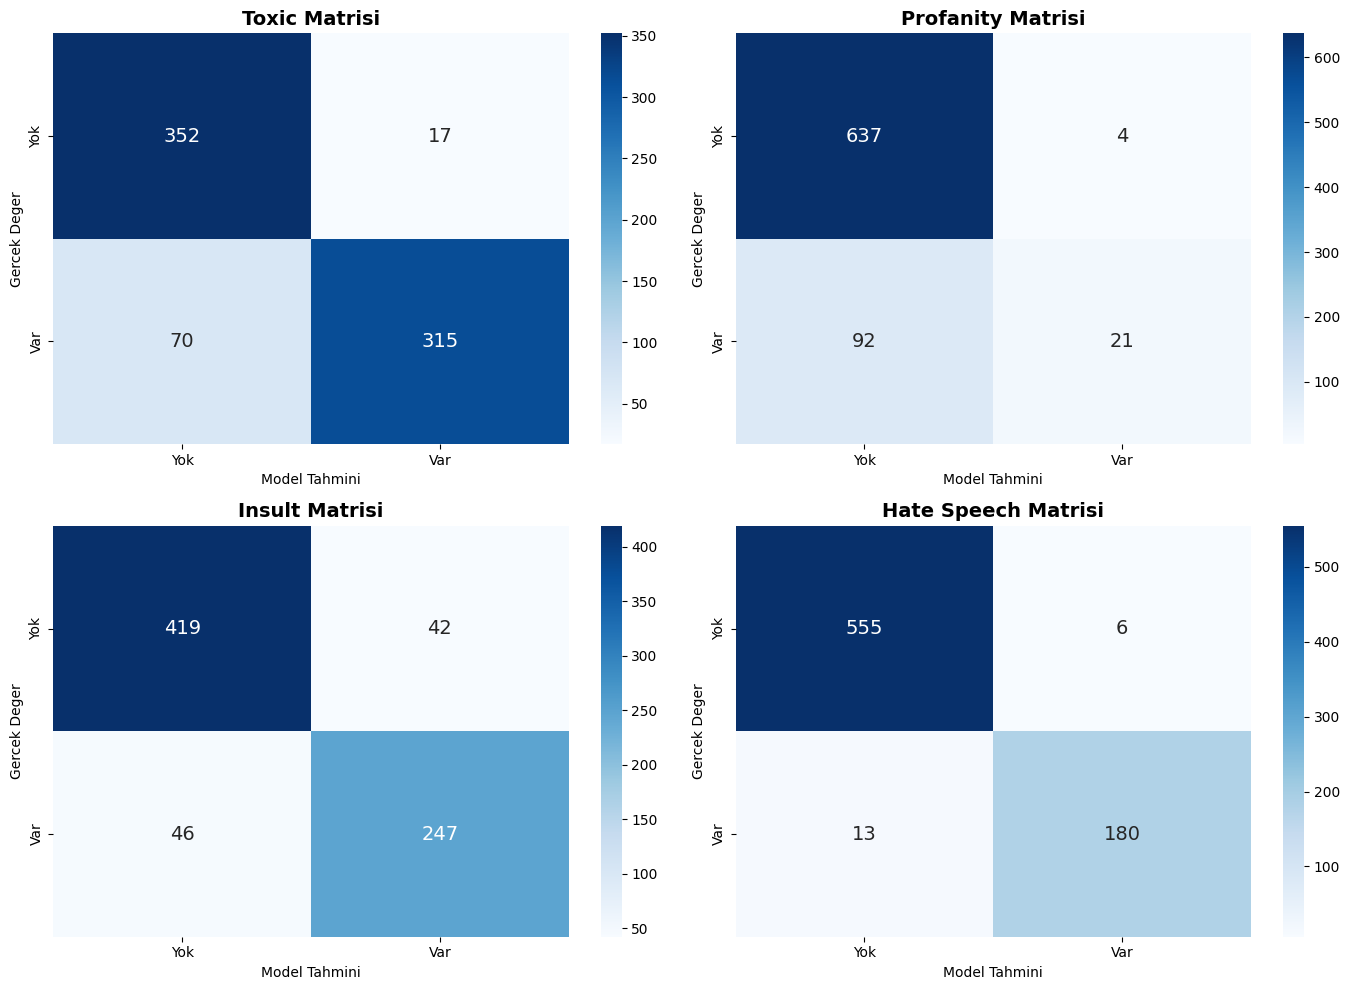

In [6]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset

# 1. AYARLAR VE YUKLEME
MODEL_PATH = "toxic_model_colab"
DATA_FILE = "augmented_train_data.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABELS = ['Toxic', 'Profanity', 'Insult', 'Hate Speech']

print("[1/4] Veri ve Model yukleniyor...")

# Veriyi oku ve Test seti ayir (%20)
df = pd.read_csv(DATA_FILE)
_, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Test edilecek satir sayisi: {len(test_df)}")

# Modeli Yukle
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()

# 2. TEST DATASET SINIFI (Hizli islem icin)
class TestDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['cleaned_text'].values
        self.labels = df[['is_toxic', 'is_profanity', 'is_insult', 'is_hate_speech']].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

test_dataset = TestDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

# 3. TAHMINLERI AL
print("[2/4] Tahminler yapiliyor (Bu islem birkac saniye surer)...")
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=mask)
        # Olasiliklari 0 ve 1'e cevir (Esik degeri 0.5)
        preds = (torch.sigmoid(outputs.logits) > 0.5).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. RAPORLAMA
print("\n[3/4] DETAYLI SINIFLANDIRMA RAPORU")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=LABELS, zero_division=0))
print("-" * 60)
print(f"Genel Accuracy (Dogruluk): {accuracy_score(all_labels, all_preds):.4f}")
print(f"Genel F1 Score (Ortalama): {f1_score(all_labels, all_preds, average='macro'):.4f}")

# 5. GORSELLESTIRME (CONFUSION MATRIX)
print("\n[4/4] Confusion Matrix ciziliyor...")
cms = multilabel_confusion_matrix(all_labels, all_preds)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cm in enumerate(cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], annot_kws={"size": 14})
    axes[i].set_title(f"{LABELS[i]} Matrisi", fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Gercek Deger')
    axes[i].set_xlabel('Model Tahmini')
    axes[i].set_xticklabels(['Yok', 'Var'])
    axes[i].set_yticklabels(['Yok', 'Var'])

plt.tight_layout()
plt.show()